<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025/blob/main/DL_day11/1_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, header=0, parse_dates=[0], index_col=0)

In [3]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


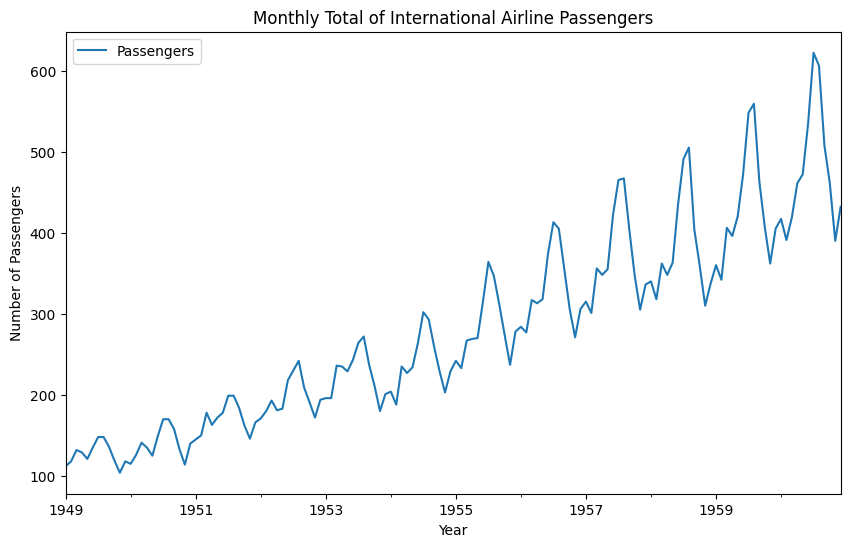

In [4]:
df.plot(figsize=(10,6))
plt.title("Monthly Total of International Airline Passengers")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

In [6]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [8]:
input_size, hidden_size, output_size = 1, 3, 1

seq_length = 12
X, y = create_sequences(data_scaled, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

model_rnn = RNNModel(input_size, hidden_size, output_size)
model_lstm = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

In [9]:
def train_model(model, optimizer, X_train, y_train, epochs=100):
    print('')
    model.train()
    train_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)

        loss = criterion(y_pred, y_train)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return model, train_losses

In [10]:
model_rnn, train_losses_rnn = train_model(model_rnn, optimizer_rnn, X_train, y_train, epochs=5000)
model_lstm, train_losses_lstm = train_model(model_lstm, optimizer_lstm, X_train, y_train, epochs=5000)

model_rnn.eval()
model_lstm.eval()

y_pred_rnn = model_rnn(X_test).detach()
y_pred_lstm = model_lstm(X_test).detach()

y_pred_rnn = scaler.inverse_transform(y_pred_rnn.numpy().reshape(-1, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.numpy().reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))


Epoch [200/5000], Loss: 0.1443
Epoch [400/5000], Loss: 0.1032
Epoch [600/5000], Loss: 0.0652
Epoch [800/5000], Loss: 0.0280
Epoch [1000/5000], Loss: 0.0189
Epoch [1200/5000], Loss: 0.0174
Epoch [1400/5000], Loss: 0.0162
Epoch [1600/5000], Loss: 0.0152
Epoch [1800/5000], Loss: 0.0143
Epoch [2000/5000], Loss: 0.0136
Epoch [2200/5000], Loss: 0.0130
Epoch [2400/5000], Loss: 0.0125
Epoch [2600/5000], Loss: 0.0121
Epoch [2800/5000], Loss: 0.0117
Epoch [3000/5000], Loss: 0.0114
Epoch [3200/5000], Loss: 0.0111
Epoch [3400/5000], Loss: 0.0109
Epoch [3600/5000], Loss: 0.0107
Epoch [3800/5000], Loss: 0.0105
Epoch [4000/5000], Loss: 0.0104
Epoch [4200/5000], Loss: 0.0102
Epoch [4400/5000], Loss: 0.0101
Epoch [4600/5000], Loss: 0.0099
Epoch [4800/5000], Loss: 0.0098
Epoch [5000/5000], Loss: 0.0096

Epoch [200/5000], Loss: 0.1917
Epoch [400/5000], Loss: 0.0570
Epoch [600/5000], Loss: 0.0234
Epoch [800/5000], Loss: 0.0230
Epoch [1000/5000], Loss: 0.0225
Epoch [1200/5000], Loss: 0.0219
Epoch [1400/50

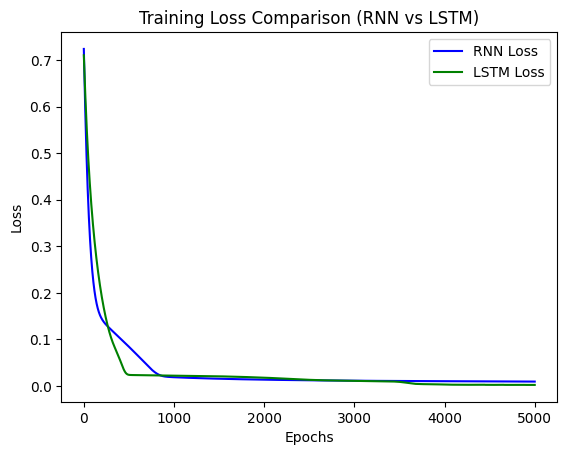

In [11]:
plt.plot(train_losses_rnn, label="RNN Loss", color='blue')
plt.plot(train_losses_lstm, label="LSTM Loss", color='green')
plt.title("Training Loss Comparison (RNN vs LSTM)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

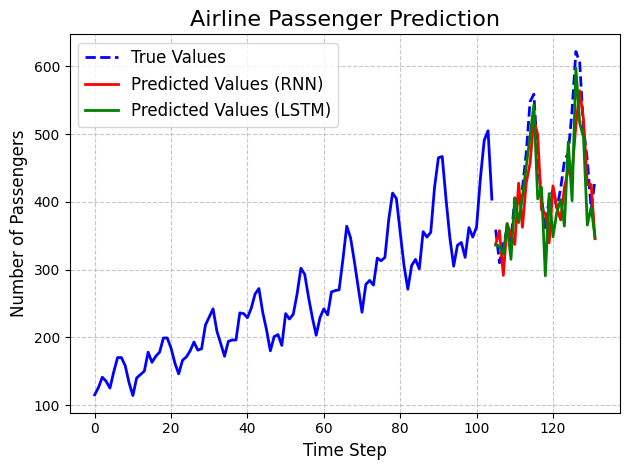

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, color='blue', linestyle='-', linewidth=2)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='True Values',  linestyle='--', color='blue', linewidth=2)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_rnn, label='Predicted Values (RNN)', color='red', linestyle='-', linewidth=2)
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_lstm, label='Predicted Values (LSTM)', color='green', linestyle='-', linewidth=2)

plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Airline Passenger Prediction", fontsize=16)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Number of Passengers", fontsize=12)

plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()